In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.font_manager as fm
import plotly.express as px

# 한글 폰트 설정
font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS 폰트 경로
font_prop = fm.FontProperties(fname = font_path) 
font_name = font_prop.get_name() # 폰트명
matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지


In [8]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')

# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print(f"변환된 데이터 크기: {pivot.shape}")
display(pivot.head())

변환된 데이터 크기: (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [9]:
from tqdm import tqdm

def safe_corr(x, y):
    # 표준편차가 0이면(값이 변하지 않으면) 상관계수를 구할 수 없으므로 0 반환
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, corr_threshold=0.4):
    items = pivot.index.to_list()
    n_months = pivot.shape[1]
    results = []

    # 모든 품목 쌍에 대해 반복 (시간이 오래 걸릴 수 있음)
    for leader in tqdm(items, desc="탐색 중"):
        x = pivot.loc[leader].values.astype(float)
        
        # 데이터가 너무 없으면 건너뜀
        if np.count_nonzero(x) < 12: continue

        for follower in items:
            if leader == follower: continue
            
            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < 12: continue

            best_lag = None
            best_corr = 0.0

            # 1개월 ~ 6개월(max_lag) 밀어서 상관계수 확인
            for lag in range(1, max_lag + 1):
                # x는 앞부분, y는 뒷부분을 잘라서 비교 (Shift 효과)
                # x(t)와 y(t+lag)를 비교함
                corr = safe_corr(x[:-lag], y[lag:])
                
                # 상관계수 절댓값이 더 크면 갱신
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 상관계수가 기준(threshold)을 넘으면 결과에 저장
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    return pd.DataFrame(results)

# 실행 예시
pairs = find_comovement_pairs(pivot)
print(f"찾은 공행성 쌍 개수: {len(pairs)}")
display(pairs.head())

탐색 중: 100%|██████████| 100/100 [00:06<00:00, 14.80it/s]

찾은 공행성 쌍 개수: 1425


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,5,-0.443984
1,AANGBULD,DEWLVASR,6,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635
3,AANGBULD,EVBVXETX,6,0.436623
4,AANGBULD,FTSVTTSR,3,0.531400


## 3. 공행성쌍 탐색
- 각 (A, B) 쌍에 대해 lag = 1 ~ max_lag까지 Pearson 상관계수 계산
- 절댓값이 가장 큰 상관계수와 lag를 선택
- |corr| >= corr_threshold이면 A→B 공행성 있다고 판단

In [12]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=12, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

pairs = find_comovement_pairs(pivot)
print("탐색된 공행성쌍 수:", len(pairs))
pairs

100it [00:12,  8.00it/s]

탐색된 공행성쌍 수: 2565


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,8,-0.480115
1,AANGBULD,BEZYMBBT,10,-0.483240
2,AANGBULD,BLANHGYY,11,0.588076
3,AANGBULD,DEWLVASR,6,0.640221
4,AANGBULD,DNMPSKTB,4,-0.410635
...,...,...,...,...
2560,ZXERAXWP,MIRCVAMV,3,-0.435495
2561,ZXERAXWP,SAAYMURU,12,0.440026
2562,ZXERAXWP,UIFPPCLR,1,-0.526205
2563,ZXERAXWP,WHPUAOID,6,0.522106


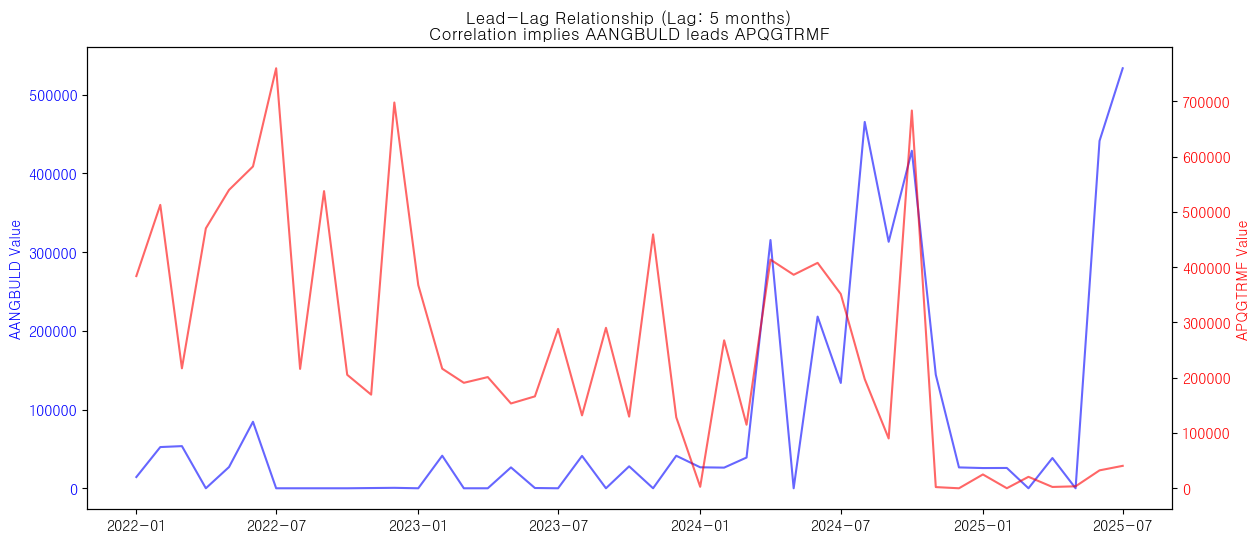

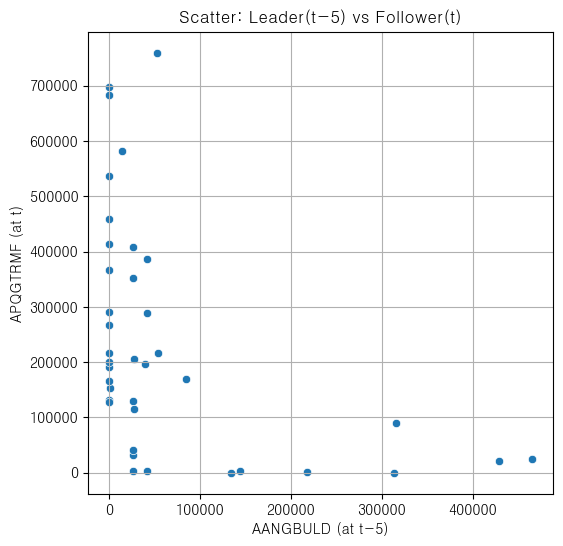

In [10]:
def plot_lagged_relationship(pivot, leader_id, follower_id, lag):
    """
    선행 품목(Leader)과 후행 품목(Follower)의 관계를 시각화합니다.
    """
    # 데이터 추출
    leader_series = pivot.loc[leader_id]
    follower_series = pivot.loc[follower_id]
    
    # 그래프 설정
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. 선행 품목 그리기 (파란색)
    ax1.plot(leader_series.index, leader_series.values, color='blue', label=f'Leader: {leader_id}', alpha=0.6)
    ax1.set_ylabel(f'{leader_id} Value', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # 2. 후행 품목 그리기 (빨간색) - 값을 비교하기 쉽게 이중 축 사용
    ax2 = ax1.twinx()
    ax2.plot(follower_series.index, follower_series.values, color='red', label=f'Follower: {follower_id}', alpha=0.6)
    ax2.set_ylabel(f'{follower_id} Value', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 3. Lag 시점 표시 (옵션)
    plt.title(f"Lead-Lag Relationship (Lag: {lag} months)\nCorrelation implies {leader_id} leads {follower_id}")
    plt.show()

    # 4. 산점도 (Scatter Plot) - 우상향하면 예측력 높음
    plt.figure(figsize=(6, 6))
    
    # Leader를 lag만큼 밀어서 데이터 매칭
    x_val = leader_series.values[:-lag] # 과거의 Leader
    y_val = follower_series.values[lag:] # 현재의 Follower
    
    sns.scatterplot(x=x_val, y=y_val)
    plt.title(f"Scatter: Leader(t-{lag}) vs Follower(t)")
    plt.xlabel(f"{leader_id} (at t-{lag})")
    plt.ylabel(f"{follower_id} (at t)")
    plt.grid(True)
    plt.show()

# --- 실행 예시 ---
# pairs 데이터프레임에서 첫 번째로 발견된 쌍을 그려봅니다.
if not pairs.empty:
    sample = pairs.iloc[0] # 첫 번째 행 가져오기
    plot_lagged_relationship(
        pivot, 
        leader_id=sample['leading_item_id'], 
        follower_id=sample['following_item_id'], 
        lag=int(sample['best_lag'])
    )
else:
    print("조건에 맞는 쌍을 찾지 못했습니다.")